In [4]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import yaml
from tqdm import tqdm
import lovelyplots
import scienceplots

the functional contents of this notebook are moved into corral_crowding/speedlimit_fit.py so can be imported and incorporated in the numerical optimizer. Left here is for making plots.

In [5]:
lambdaq = 0.08
alpha = 120e6
g3 = 60e6
f_SNAIL = 4.3  # 4.276  # Ghz
f0 = f_SNAIL / 2  # (e.g. ~2.138 GHz)
################
N = 200  # x-axis
d_min = 5  # Minimum allowed dBm at f0
f_left = f_SNAIL - 4.0  # 0.3  # Left endpoint frequency in GHz
d_left = 25  # Allowed dBm at f_left
###############
# assume there exists some gate duration
t_f_calib = 250e-9  # Gate duration in seconds (200 ns)
test_ghz = (f_SNAIL / 2) - 1.0  # Calibration pump frequency in GHz
################
# Define the lifetime T1 (in seconds)
T1 = 120e-6  # 120 microseconds

In [6]:
# Compute the slope for the left branch of the V-shaped speed limit:
slope = (d_left - d_min) / (f0 - f_left)
# ================================
# LOAD EXPERIMENTAL DATA
# ================================
fileName = "Q2_pumpDeath"  # or "Q3_pumpDeath"
saveDir = "/home/evm9/corral_crowding/src/notebooks/chao_data/"
data = h5py.File(saveDir + fileName, "r")

# Retrieve datasets from the HDF5 file
freqList = data["freqList"][()]  # frequencies in Hz
pwrList = data["pwrList"][()]  # pump powers in dBm
glist = data["glist"][()]  # experimental data array

# ================================
# DEFINE FUNCTIONS
# ================================


def compute_snail_aware_max_dBm(frequency_GHz):
    """Returns the maximum allowed pump power (in dBm) for a given pump frequency,
    using a linear (V-shaped) speed limit with a minimum at f0 = f_SNAIL/2.

    Assumptions:
      - At f_left (0.3 GHz): allowed pump power is d_left (25 dBm).
      - At f0 (f_SNAIL/2): allowed pump power is d_min (5 dBm).
    """  # noqa: D205
    return d_min + slope * np.abs(frequency_GHz - f0)


def fit_epsilon(dBm_calib, t_f_calib, g3, lambda_factor, w_pump, w_snail):
    """Calibrates the conversion factor (X_factor) between pump power (in dBm)
    and the effective drive amplitude ε.

    Using:
      (1) (π/2) = 6 g3 |η| λ² t_f_calib
      (2) |η| = (ε * w_snail) / (w_pump² - w_snail²)

    Rearranging, one finds:
      |η|_calib = π / (12 g3 λ² t_f_calib)
      ε_calib = |η|_calib (w_pump² - w_snail²) / w_snail

    Then, assuming a linear relation ε = X_factor * (pump power in dBm):
      X_factor = ε_calib / dBm_calib
    """  # noqa: D205
    eta_calib = np.pi / (12 * t_f_calib * g3 * lambda_factor**2)
    epsilon_calib = eta_calib * (w_pump**2 - w_snail**2) / w_snail
    X_factor = epsilon_calib / dBm_calib
    return epsilon_calib, X_factor


def compute_gate_duration(frequency_GHz, X_factor, g3, lambda_factor):
    """Computes the gate duration t_f (in seconds) for a given pump frequency (in GHz)
    using the calibrated conversion factor (X_factor). Uses the global f_SNAIL.

    The relations used are:
      (1) |η| = (ε * w_snail) / (w_pump² - w_snail²), with ε = X_factor * (pump power in dBm)
      (2) (π/2) = 6 g3 |η| λ² t_f   →   t_f = π / (12 g3 λ² |η|)

    Here, w_pump and w_snail are the pump and SNAIL angular frequencies (rad/s), respectively.
    """  # noqa: D205
    w_pump = 2 * np.pi * frequency_GHz * 1e9
    w_snail = 2 * np.pi * f_SNAIL * 1e9
    max_dBm = compute_snail_aware_max_dBm(frequency_GHz)
    epsilon = X_factor * max_dBm
    eta_val = epsilon * w_snail / (w_pump**2 - w_snail**2)
    t_f = np.pi / (12 * eta_val * g3 * lambda_factor**2)
    return t_f

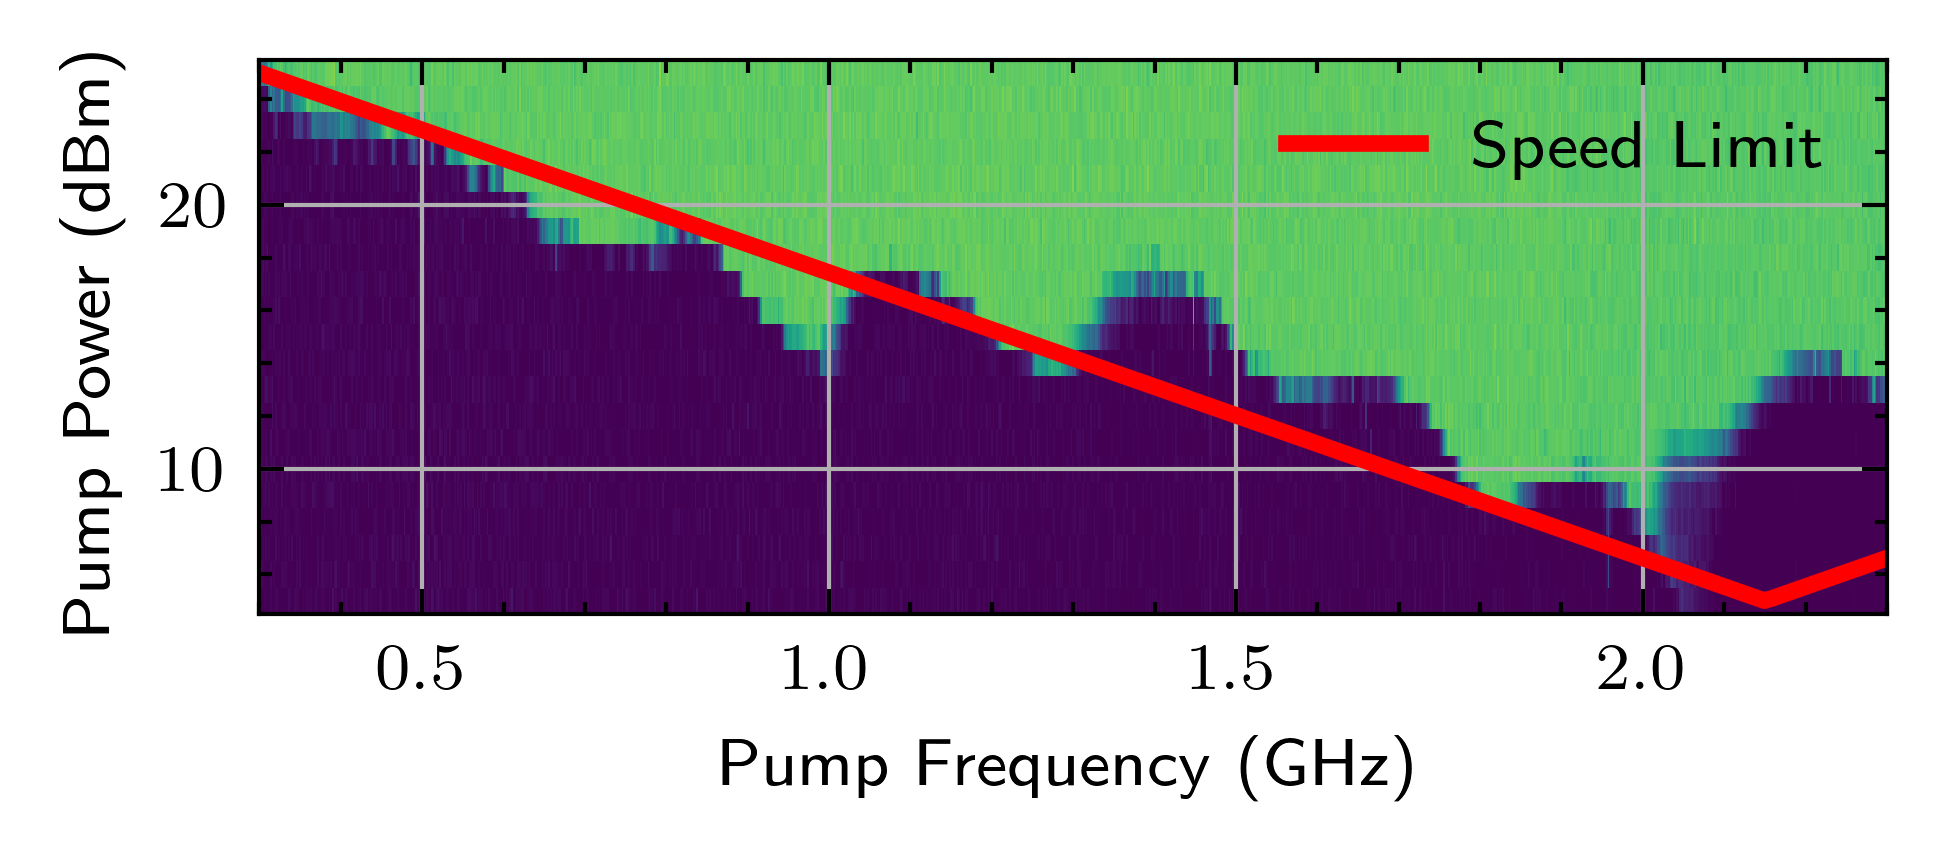

In [7]:
# ================================
# PLOT: Experimental Data with Speed Limit Overlay
# ================================
# Generate x-values over the experimental range (0.3 to 2.3 GHz)
frequency_range_GHz = np.linspace(f_left, f_left + 2, N)
y_vals = compute_snail_aware_max_dBm(frequency_range_GHz)

with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 1.2))
    # Plot the experimental data (convert frequency from Hz to GHz)
    cmesh = ax.pcolormesh(
        freqList / 1e9,
        pwrList,
        glist.T,
        shading="auto",
        cmap="viridis_r",
        vmin=-0.1,
        vmax=0.9,
    )
    ax.set_xlabel("Pump Frequency (GHz)")
    ax.set_ylabel("Pump Power (dBm)")
    # ax.set_xticks([0.5, 1, 1.5, 2])
    # ax.set_yticks([5, 10, 15, 20, 25])
    # Optionally add a colorbar:
    # fig.colorbar(cmesh, ax=ax, ticks=[0, 1])
    # Overlay the speed limit curve
    ax.plot(frequency_range_GHz, y_vals, color="red", linewidth=2, label="Speed Limit")
    ax.legend()
    ax.set_xlim(f_left, f_left + 2)
    ax.grid(True)
    # plt.title("Pump Data with Speed Limit")
plt.show()

Calibration: ε = -6.841e+10 and X_factor = -4.327e+09


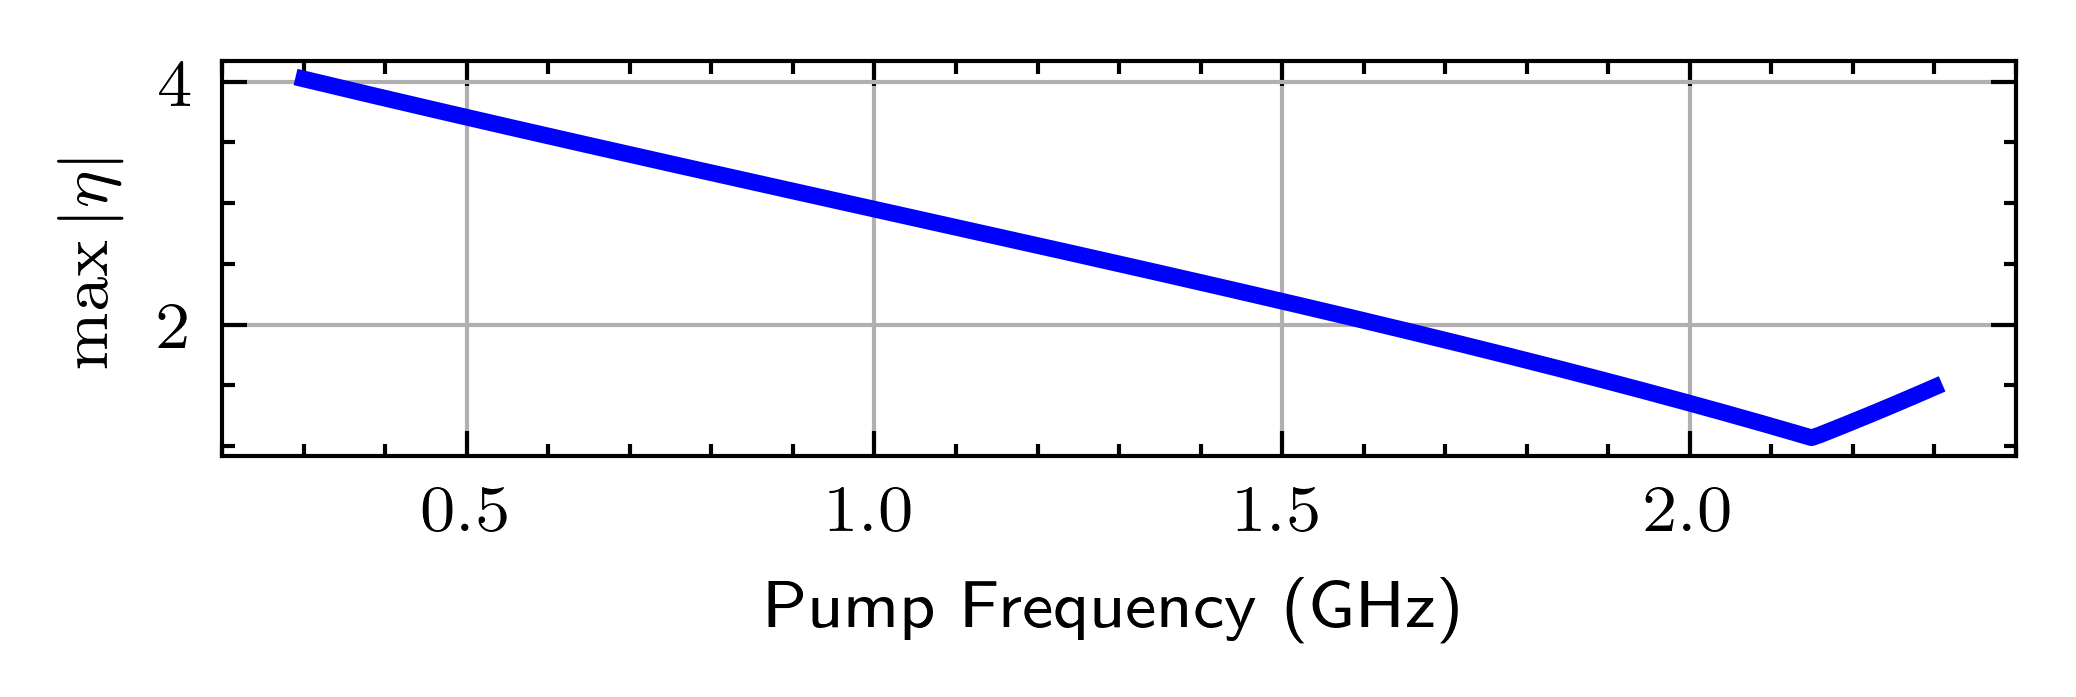

In [8]:
# ================================
# CALIBRATION: Fit the conversion factor from dBm to ε
# ================================
# Calibration: use pump frequency = test_ghz, gate duration = t_f_calib.
w_pump_calib = 2 * np.pi * test_ghz * 1e9
w_snail_calib = 2 * np.pi * f_SNAIL * 1e9
dBm_calib = compute_snail_aware_max_dBm(test_ghz)

epsilon_calib, X_factor = fit_epsilon(
    dBm_calib, t_f_calib, g3, lambdaq, w_pump_calib, w_snail_calib
)
print(f"Calibration: ε = {epsilon_calib:.3e} and X_factor = {X_factor:.3e}")

# ================================
# PLOT: |η| vs. Pump Frequency
# ================================
# Use the same pump frequency range as before.
eta_values = []

for f in frequency_range_GHz:
    # Convert pump and SNAIL frequencies to angular frequencies (rad/s)
    w_pump = 2 * np.pi * f * 1e9
    w_snail = 2 * np.pi * f_SNAIL * 1e9

    # Get the maximum allowed pump power (in dBm) for this frequency.
    max_dBm = compute_snail_aware_max_dBm(f)

    # Compute the effective drive amplitude ε using the calibrated conversion factor.
    epsilon = X_factor * max_dBm

    # Calculate η (note: the denominator can be negative, so we take the absolute value later)
    eta_val = epsilon * w_snail / (w_pump**2 - w_snail**2)

    # Append the absolute value of η.
    eta_values.append(np.abs(eta_val))

eta_values = np.array(eta_values)

with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 1.2))
    ax.plot(frequency_range_GHz, eta_values, "b-", linewidth=2)
    ax.set_xlabel("Pump Frequency (GHz)")
    ax.set_ylabel(r"$\max{|\eta|}$")
    ax.grid(True)
    plt.tight_layout()
plt.show()

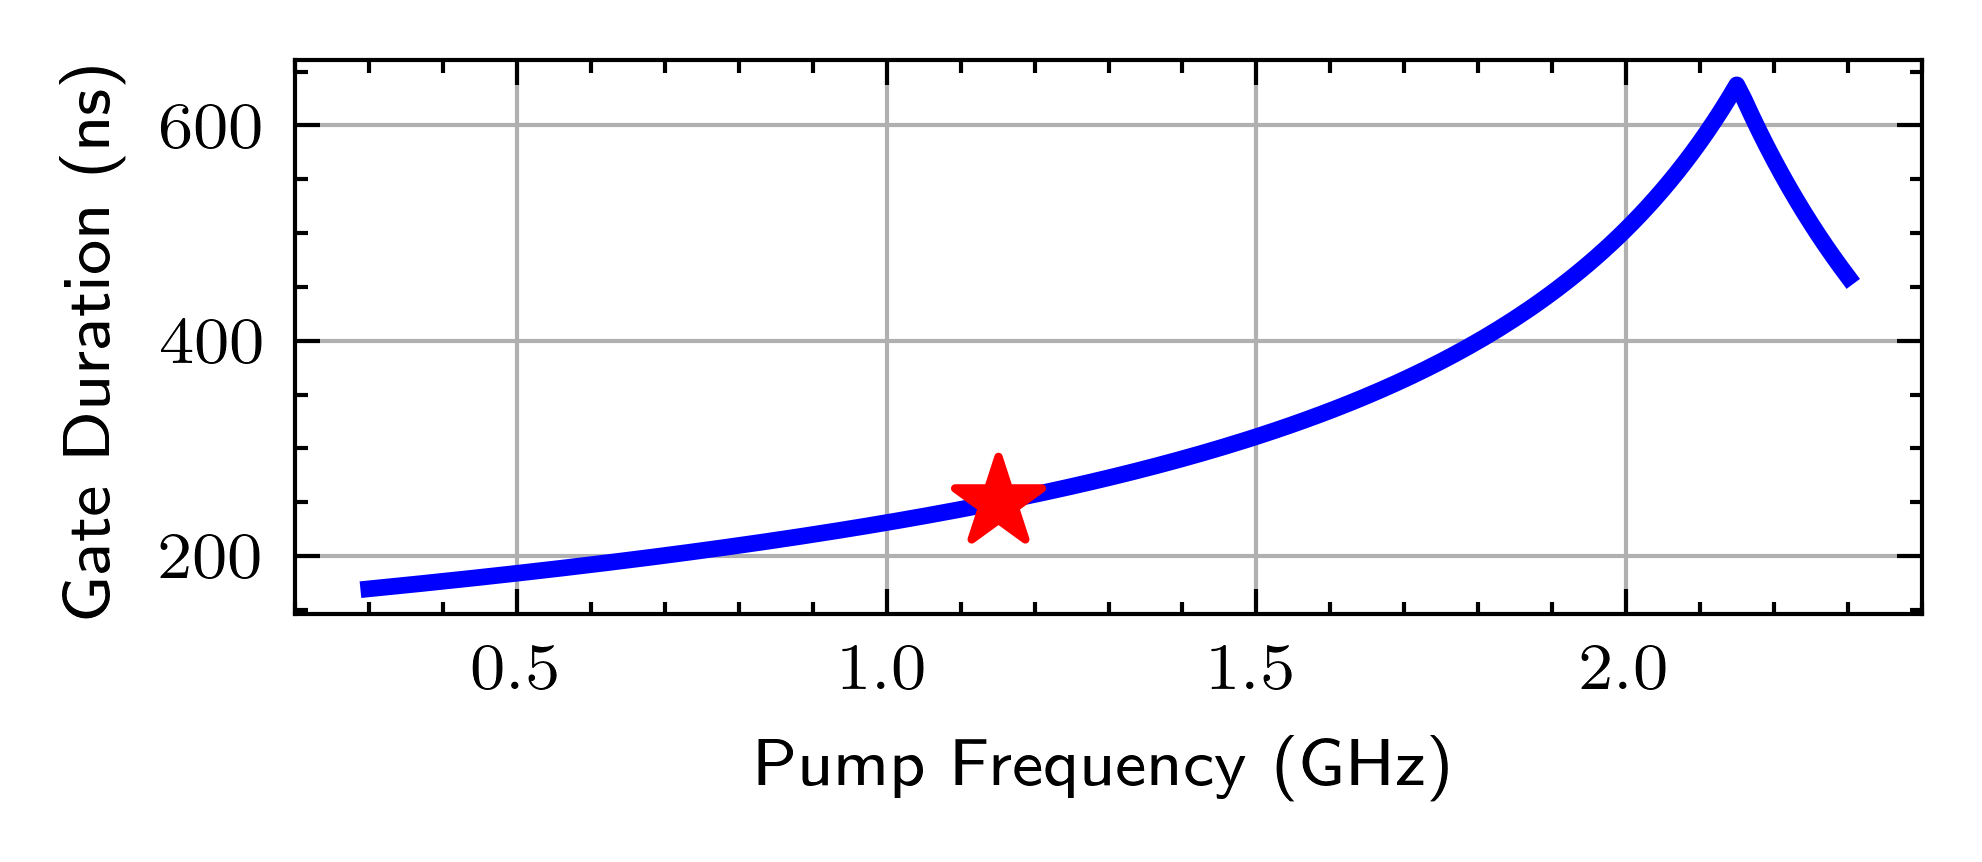

In [9]:
# ================================
# PLOT: Minimum Gate Duration (t_f) vs. Pump Frequency
# ================================
gate_durations = np.array(
    [compute_gate_duration(f, X_factor, g3, lambdaq) for f in frequency_range_GHz]
)

with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 1.2))
    ax.scatter(test_ghz, t_f_calib * 1e9, marker="*", color="red", s=120, zorder=3)
    ax.plot(frequency_range_GHz, gate_durations * 1e9, "b-", linewidth=2)
    ax.set_xlabel("Pump Frequency (GHz)")
    ax.set_ylabel("Gate Duration (ns)")
    ax.grid(True)
plt.show()

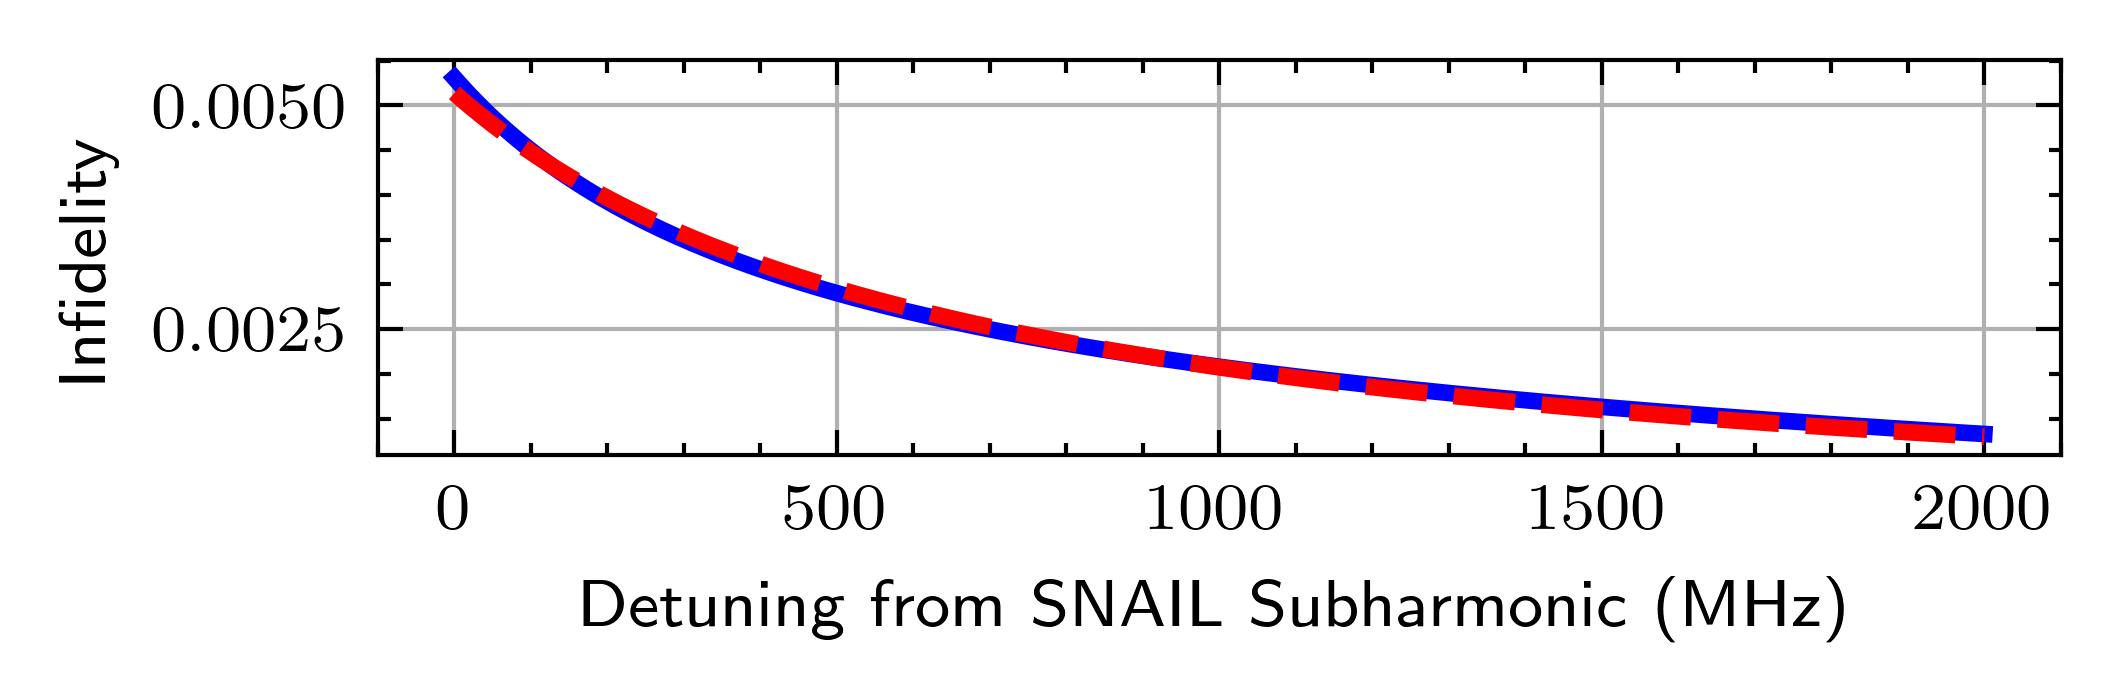

In [10]:
# -------------------------------------------------
# Final Plot: Estimated Infidelity vs. Detuning
# -------------------------------------------------
# We want the detuning axis to go from 0 to 1000 MHz.
# Since detuning (MHz) = (f_pump - f0) * 1e3, choose pump frequencies accordingly.
pump_freq_range = np.linspace(f0, f0 - 2, N)  # f0 to f0+1 GHz => 0 to 2000 MHz detuning

# Compute the gate durations for each pump frequency using the calibrated X_factor.
detuned_durations = np.array(
    [compute_gate_duration(f, X_factor, g3, lambdaq) for f in pump_freq_range]
)

# Estimate the infidelity for each frequency using: infidelity = exp(-t_f/T1)
infidelity = 1 - np.exp(-detuned_durations / T1)

# Compute the detuning in MHz:
detuning_MHz = np.abs((pump_freq_range - f0) * 1e3)

import numpy as np
from scipy.optimize import curve_fit

# from corral_crowding.detuning_fit import decay_fit, fit_infidelity


def lifetime_decay_fit(detuning, x0, x1):
    """Modified ansatz for fitting infidelity curves."""
    return x0 / (x1 + detuning)


def fit_infidelity(detuning_list, infidelity_list):
    """Fits the infidelity data to the modified power-law model with better convergence."""
    p0 = [1, 1]  # Improved initial guess
    params, _ = curve_fit(lifetime_decay_fit, detuning_list, infidelity_list, p0=p0)
    # print(params)
    return params


params = fit_infidelity(detuning_MHz, infidelity)
fit_line = lifetime_decay_fit(detuning_MHz, *params)


# Create the final plot with x-axis from 0 to 1000 MHz.
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 1.2))
    ax.plot(detuning_MHz, infidelity, "b-", linewidth=2)
    ax.plot(detuning_MHz, fit_line, "r--", linewidth=2)
    ax.set_xlabel("Detuning from SNAIL Subharmonic (MHz)")
    ax.set_ylabel("Infidelity")
    # ax.set_xlim(0, 1000)  # x-axis from 0 to 1000 MHz
    ax.grid(True)
    # ax.set_yscale("log")
    plt.tight_layout()
plt.show()

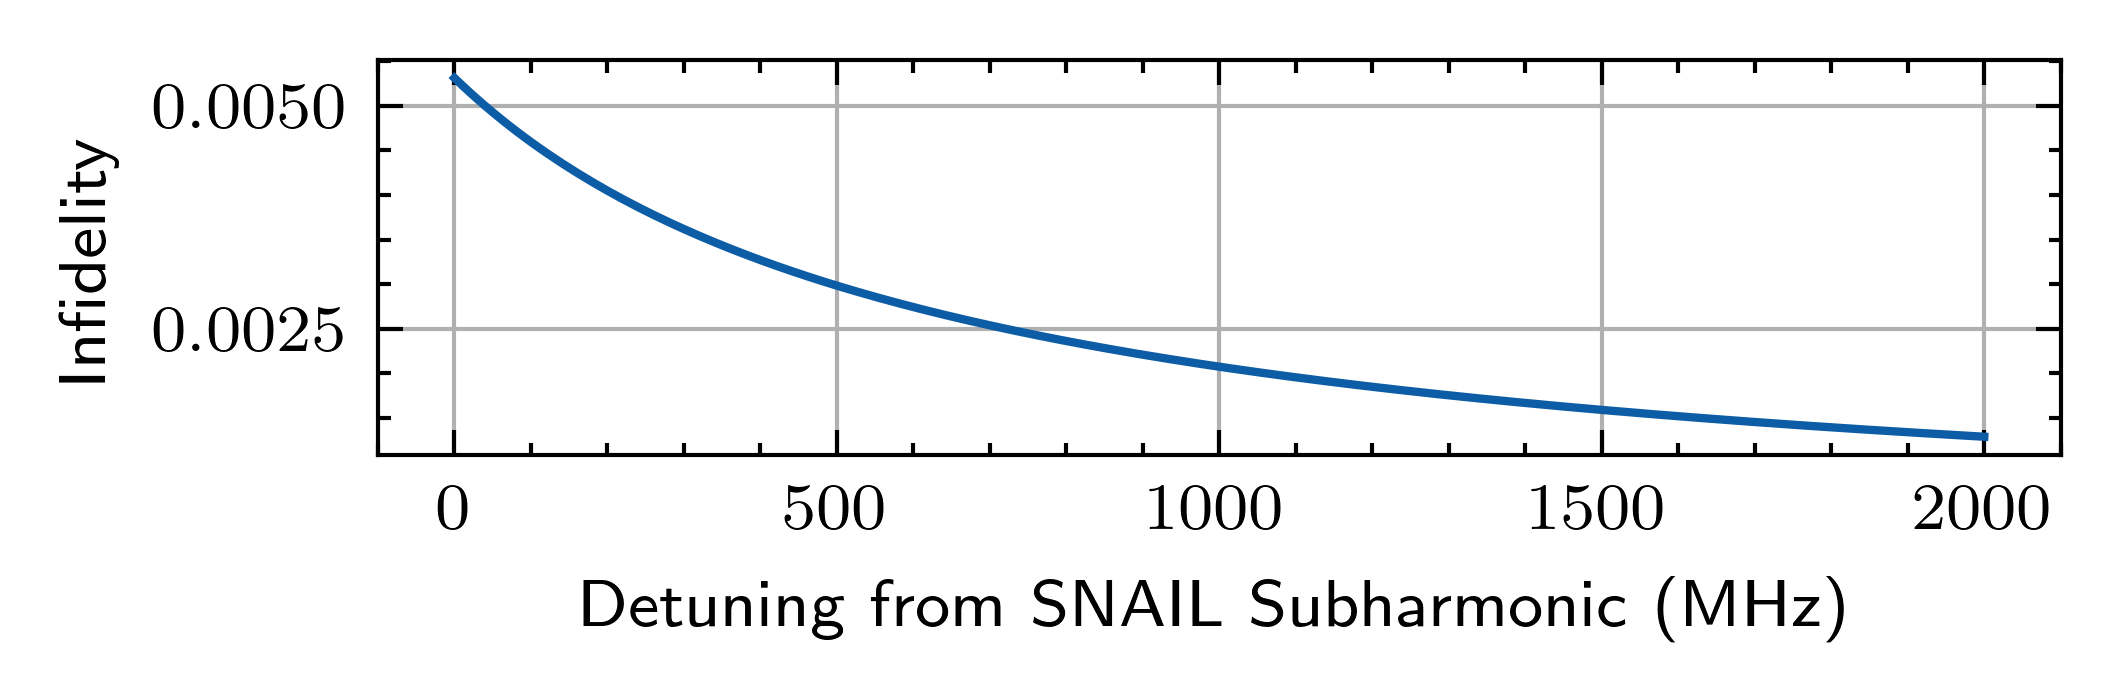

In [11]:
# make sure this works from the imported module too
from corral_crowding.speedlimit_fit import (
    speedlimit_infidelity_params,
    lifetime_decay_fit,
)

snail_bounds = (4.2, 4.7)

infidelity_params, fidelity_results = speedlimit_infidelity_params(
    f_SNAIL=4.45, t_f_calib=t_f_calib, T1=T1, g3=g3, lambdaq=lambdaq
)

# Create the final plot with x-axis from 0 to 1000 MHz.
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 1.2))
    ax.plot(detuning_MHz, lifetime_decay_fit(detuning_MHz, *infidelity_params))
    ax.set_xlabel("Detuning from SNAIL Subharmonic (MHz)")
    ax.set_ylabel("Infidelity")
    # ax.set_xlim(0, 1000)  # x-axis from 0 to 1000 MHz
    ax.grid(True)
    # ax.set_yscale("log")
    plt.tight_layout()
plt.show()

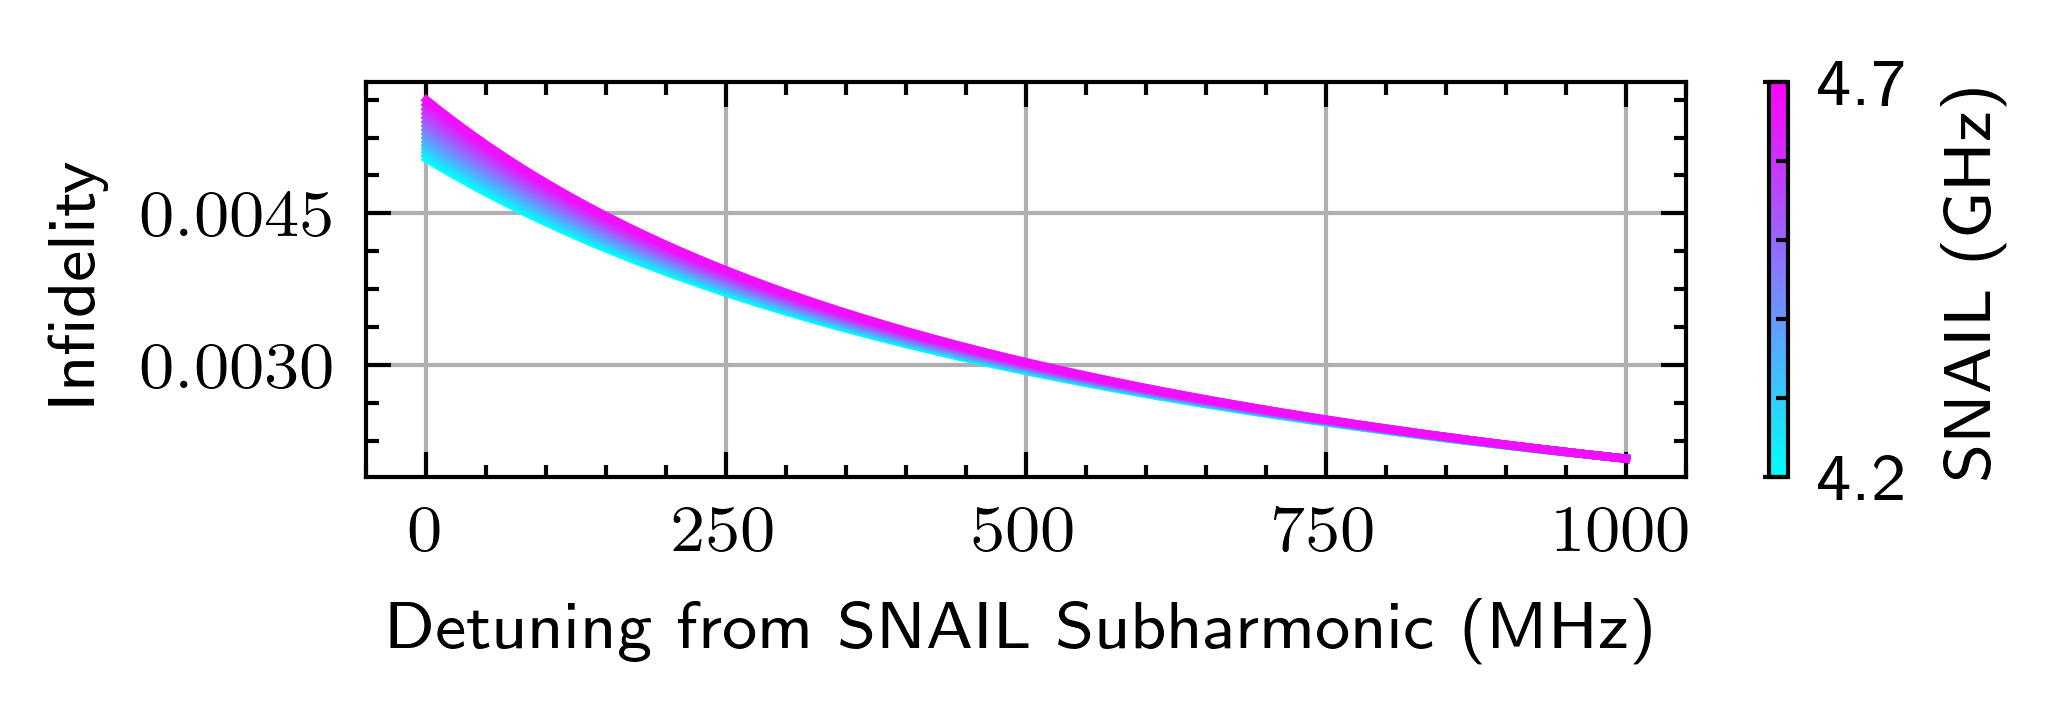

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from corral_crowding.speedlimit_fit import (
    speedlimit_infidelity_params,
    lifetime_decay_fit,
)
from matplotlib.ticker import MaxNLocator

# Define the range of SNAIL frequencies to sweep over
snail_bounds = (4.2, 4.7)
snail_frequencies = np.linspace(
    snail_bounds[0], snail_bounds[1], num=16
)  # Sweep 10 values

# Detuning range for plotting (consistent with previous code)
detuning_MHz = np.linspace(0, 1000, N)

# Prepare plot
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 1.2))

    # Use a colormap to differentiate SNAIL frequencies
    cmap = plt.get_cmap("cool")
    colors = [cmap(i / len(snail_frequencies)) for i in range(len(snail_frequencies))]

    # Iterate over SNAIL frequencies and compute infidelity curves
    all_infidelities = []
    for i, f_SNAIL in enumerate(snail_frequencies):
        infidelity_params, _ = speedlimit_infidelity_params(
            f_SNAIL=f_SNAIL, t_f_calib=t_f_calib, T1=T1, g3=g3, lambdaq=lambdaq
        )

        # Compute infidelity values for plotting
        infidelity_values = lifetime_decay_fit(detuning_MHz, *infidelity_params)
        all_infidelities.append(infidelity_values)

        # Plot the infidelity curve for this SNAIL frequency
        ax.plot(detuning_MHz, infidelity_values, color=colors[i])

    # Determine min, max, and middle y-ticks dynamically
    inf_min, inf_max = np.min(all_infidelities), np.max(all_infidelities)
    inf_mid = (inf_min + inf_max) / 2
    # ax.set_yticks([inf_min, inf_mid, inf_max])
    # ax.set_yticklabels([f"{inf_min:.1e}", f"{inf_mid:.1e}", f"{inf_max:.1e}"])
    ax.yaxis.set_major_locator(MaxNLocator(3))

    # Customize plot
    ax.set_xlabel("Detuning from SNAIL Subharmonic (MHz)")
    ax.set_ylabel("Infidelity")
    ax.grid(True)
    plt.tight_layout()

    # Configure colorbar with only min and max ticks
    sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=snail_bounds[0], vmax=snail_bounds[1])
    )
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_ticks([snail_bounds[0], snail_bounds[1]])
    cbar.set_ticklabels([f"{snail_bounds[0]:.1f}", f"{snail_bounds[1]:.1f}"])
    cbar.set_label("SNAIL (GHz)")

# Show the plot
plt.show()

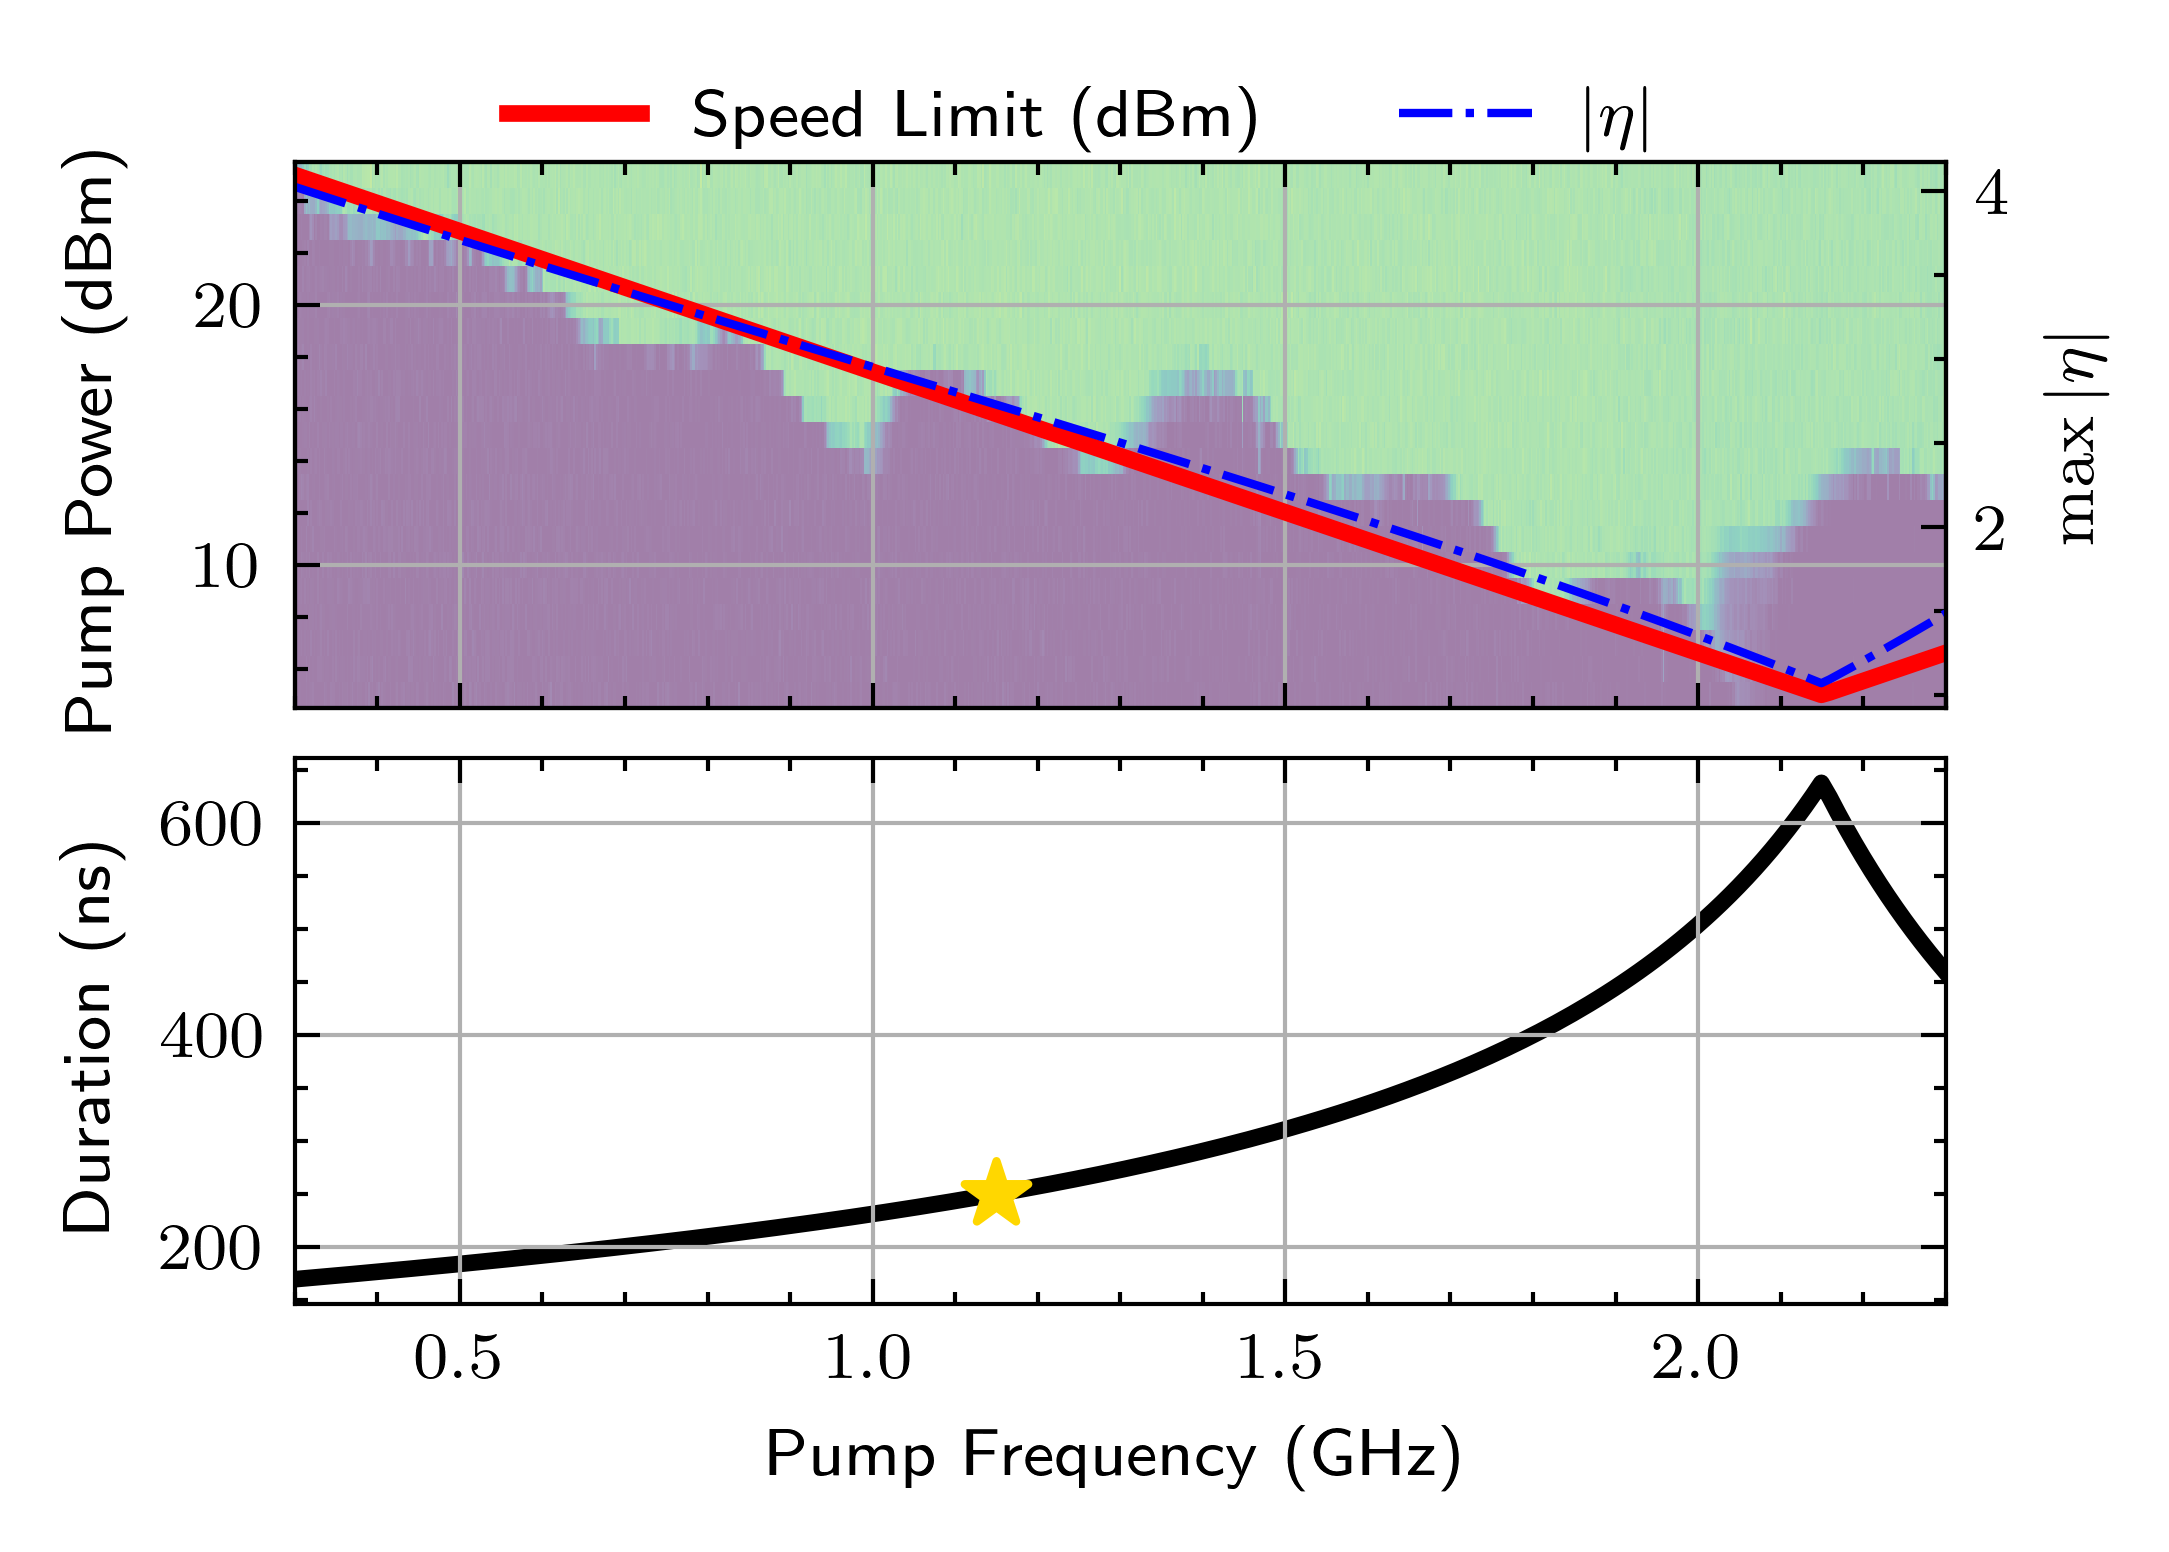

In [31]:
from matplotlib.ticker import MaxNLocator, FuncFormatter

# ---------------------------
# FINAL COMBINED PLOT: Three Vertically Stacked Subplots
# ---------------------------
with plt.style.context(["ieee", "use_mathtext", "science"]):
    # Create 3 subplots, with a total figure height scaled to 3 * 1.2 inches.
    fig, axs = plt.subplots(2, 1, figsize=(3.5, 2.3), constrained_layout=True)

    # ------------------------------------------------
    # Subplot 1: Experimental Data with Speed Limit and Twin y-axis for |η|
    # ------------------------------------------------
    ax1 = axs[0]
    # Plot experimental data as a pcolormesh (pump frequency in GHz vs. pump power in dBm)
    pcm = ax1.pcolormesh(
        freqList / 1e9,
        pwrList,
        glist.T,
        shading="nearest",
        cmap="viridis_r",
        vmin=-0.1,
        vmax=0.9,
        alpha=0.5,
        rasterized=True,
    )
    # Plot the speed limit curve (pump power in dBm) on the left y-axis
    ax1.plot(
        frequency_range_GHz, y_vals, color="red", linewidth=2, label="Speed Limit (dBm)"
    )
    # ax1.set_xlabel("Pump Frequency (GHz)")
    ax1.set_ylabel("Pump Power (dBm)")
    ax1.set_xticks([0.5, 1, 1.5, 2])
    ax1.set_xticklabels([])
    # ax1.set_yticks([5, 10, 15, 20, 25])
    # ax1.set_xlim(f_left, 2.3)
    ax1.grid(True)

    # Create a twin y-axis to plot |η| (which is a linear transform of pump power)
    ax1_twin = ax1.twinx()
    ax1_twin.plot(
        frequency_range_GHz,
        eta_values,
        "-.",
        color="blue",
        # linewidth=1,
        label=r"$|\eta|$",
    )
    ax1_twin.set_ylabel(r"$\max{|\eta|}$")
    # ax1_twin.legend(loc="upper right")
    fig.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.08),  # Moves legend above the first plot
        ncol=2,  # Arrange in 2 columns
        frameon=False,  # Optional: Remove border for cleaner look
    )

    # ------------------------------------------------
    # Subplot 2: Minimum Gate Duration (t_f) vs. Pump Frequency
    # ------------------------------------------------
    ax2 = axs[1]
    # Plot the computed gate durations (converted to ns)
    ax2.plot(
        frequency_range_GHz,
        gate_durations * 1e9,
        "-",
        color="black",
        linewidth=2,
        zorder=1,
    )
    # Plot the calibration star marker with a high zorder so it appears on top
    ax2.scatter(test_ghz, t_f_calib * 1e9, marker="*", color="gold", s=64, zorder=3)
    ax2.set_xlabel("Pump Frequency (GHz)")
    ax2.set_ylabel("Duration (ns)")
    ax2.grid(True)

    # # # ------------------------------------------------
    # # # Subplot 3: Estimated Infidelity vs. Detuning (using pink)
    # # # ------------------------------------------------
    # ax3 = axs[2]
    # # Use a colormap to differentiate SNAIL frequencies
    # cmap = plt.get_cmap("cool")
    # colors = [cmap(i / len(snail_frequencies)) for i in range(len(snail_frequencies))]

    # # Iterate over SNAIL frequencies and compute infidelity curves
    # all_infidelities = []
    # for i, f_SNAIL in enumerate(snail_frequencies):
    #     infidelity_params, _ = speedlimit_infidelity_params(
    #         f_SNAIL=f_SNAIL, t_f_calib=t_f_calib, T1=T1, g3=g3, lambdaq=lambdaq
    #     )

    #     # Compute infidelity values for plotting
    #     infidelity_values = lifetime_decay_fit(detuning_MHz, *infidelity_params)
    #     all_infidelities.append(infidelity_values)

    #     # Plot the infidelity curve for this SNAIL frequency
    #     ax3.plot(detuning_MHz, infidelity_values, color=colors[i])

    # # Determine min, max, and middle y-ticks dynamically
    # inf_min, inf_max = np.min(all_infidelities), np.max(all_infidelities)
    # inf_mid = (inf_min + inf_max) / 2
    # # ax3.set_yticks([inf_min, inf_mid, inf_max])
    # # ax3.set_yticklabels(
    # #     [f"{val:.1e}".lstrip("0") for val in [inf_min, inf_mid, inf_max]]
    # # )
    # ax3.yaxis.set_major_locator(MaxNLocator(3))
    # ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))

    # # Customize plot
    # ax3.set_xlabel("Detuning from SNAIL Subharmonic (MHz)")
    # ax3.set_ylabel("Infidelity")
    # ax3.grid(True)

    # # Configure colorbar with only min and max ticks
    # sm = plt.cm.ScalarMappable(
    #     cmap=cmap, norm=plt.Normalize(vmin=snail_bounds[0], vmax=snail_bounds[1])
    # )
    # cbar = plt.colorbar(sm, ax=ax3, pad=-0.1)
    # cbar.set_ticks([snail_bounds[0], snail_bounds[1]])
    # cbar.set_ticklabels([f"{snail_bounds[0]:.1f}", f"{snail_bounds[1]:.1f}"])
    # cbar.set_label("SNAIL (GHz)")

    #######################
    # Ensure same x-axis range for both subplots
    x_min, x_max = frequency_range_GHz[0], frequency_range_GHz[-1]
    ax1.set_xlim(x_min, x_max)
    ax2.set_xlim(x_min, x_max)
    # ax3.set_xlim(0, 1000)  # x-axis from 0 to 1000 MHz
    # set yaxis label pad
    ax1.yaxis.labelpad = 8
    ax2.yaxis.labelpad = 4
    # ax3.yaxis.labelpad = 2

plt.show()
fig.savefig("speedlimit_combined.pdf", bbox_inches="tight")